[View in Colaboratory](https://colab.research.google.com/github/Claude47/speech_music_discrimination/blob/master/feature_extraction.ipynb)

Sound Class

In [0]:
'''
    features.py
    Prototyping feature extraction
    09/04/2018
'''

import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import wave
from os.path import *
import os

from google.colab import files

def upload_local_file():
    '''used to upload local .wav files f'''
    uploaded = files.upload()

    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))

class sound:    
    raw_audio = 0
    def __init__(self, path):
        '''sound object, initialise with path to .wav file'''
        self.path = path
        self.file = wave.open(path, 'rb')
        self.frame_count = self.file.getnframes()
 
    def parameters(self):
        '''returns parameters of .wav [nchannels, sampwidth, framerate, nframes, comptype, compname]'''
        return self.file.getparams()

    def close(self):
        return self.file.close()
  
    def extract_raw_audio(self): 
        '''extract raw audio needed for dsp'''
        signal = self.file.readframes(-1)
        self.raw_audio = np.fromstring(signal,'int16')
      
    def visualise_time(self):
        '''plot raw_audio'''
        plt.plot(self.raw_audio)
        plt.show()
              
         

Saving mssp4.wav to mssp4.wav
User uploaded file "mssp4.wav" with length 220544 bytes
[  -89   -68   -82 ... -2995  -127   584]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


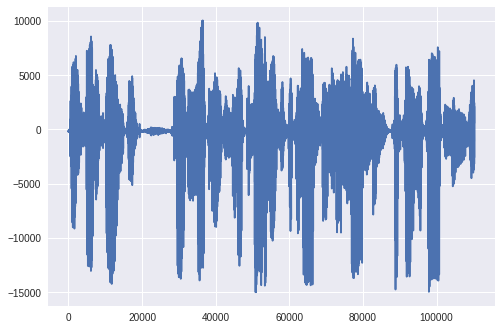

_wave_params(nchannels=1, sampwidth=2, framerate=22050, nframes=110250, comptype='NONE', compname='not compressed')


In [3]:
'''Test visualisation'''  
upload_local_file()
path = "mssp4.wav"
sound1 = sound(path) 
sound1.extract_raw_audio()

print(sound1.raw_audio)
sound1.visualise_time()
print(sound1.parameters())
         

### Low energy frames feature extraction

This is a good measure of how much of a signal is quiet relative to the rest of a signal.



In [0]:
def extract_low_energy_frames(sound):
    '''step1: break raw into frames'''
    sound.extract_raw_audio()
    raw = sound.raw_audio
    
    fs = sound.parameters()[2] #framerate
    nframes = sound.parameters()[3] #number of frames
    threshold = 1000
     
    '''step2: use threshold to identify silence'''
    silent,loud = 0,0
    for i in range(0,nframes):  
        if(abs(raw[i])>threshold):
            loud=loud+1
        else:
            silent=silent+1
    
    '''step3: calculate % of low energy frames'''
    print(silent)
    print(loud)
    print(silent+loud," ",nframes)
    return (silent/nframes)*100
   

In [8]:
'''Test percentage of low energy frames feature extraction'''
upload_local_file()
path = "msms1.wav" #speech
path2 = "msmn1.wav" #music
sound1 = sound(path)
sound2 = sound(path2)
percent1 = extract_low_energy_frames(sound1)
percent2 = extract_low_energy_frames(sound2)
print(percent1)
print(percent2)

#results seem to match speech has high percentage silence, music has low, need 
#to tweaek threshold possibly

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


21222
89028
110250   110250
31696
78554
110250   110250
19.248979591836736
28.749206349206347


In [4]:
!pip install dropbox

    100% |████████████████████████████████| 471kB 2.2MB/s 


In [0]:
import dropbox

In [0]:
access_token = 'jym07rxV7JAAAAAAAAAASYVjyBOd0G9JJKzC_5dgzrDHKeVsdZG1akcSvWnYBoKd'
dbx = dropbox.Dropbox(access_token)

In [0]:
response = dbx.files_list_folder("")

In [0]:
app_folder = '/Apps/dsp_project'

In [13]:
response.entries[0].name

'msmn1.wav'

In [0]:
metadata, res = dbx.files_download(join(app_folder, response.entries[0].name))

In [22]:
join(app_folder, response.entries[0].name)

'/Applications/dsp_project/msmn1.wav'